# Income predictions of USA census dataset from 1994 to 1996

Importing necessary packages

In [111]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE


In [4]:
df = pd.read_csv('adult.data')

In [5]:
df.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [6]:
headers = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','Target']

In [7]:
df.columns = headers

In [8]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [9]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [10]:
df.shape

(32560, 15)

In [11]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
Target            0
dtype: int64

In [12]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
Target            object
dtype: object

In [13]:
df['Target'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [14]:
more_than_50k = df[df['Target'].str.strip()=='>50K']
less_than_50k = df[df['Target'].str.strip()=='<=50K']

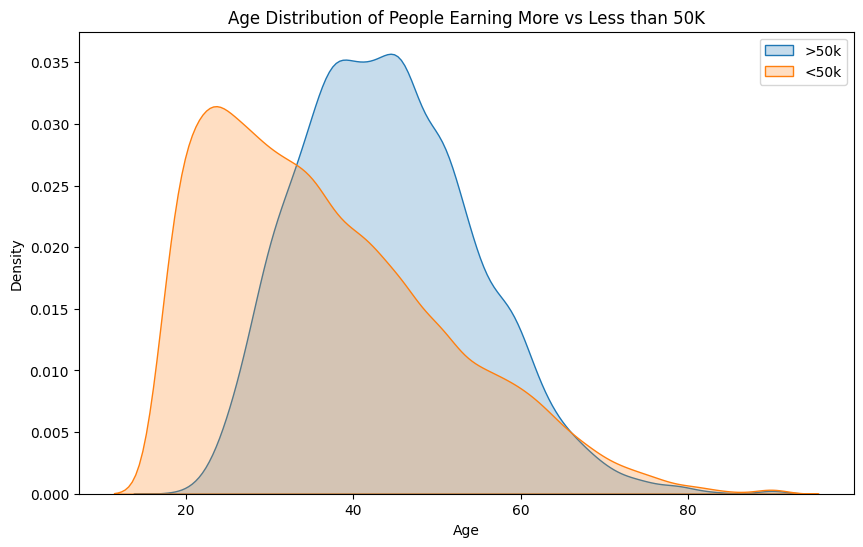

In [15]:
plt.figure(figsize=(10,6))
sns.kdeplot(data = more_than_50k,x='age' ,label='>50k', fill=True )
sns.kdeplot(data=less_than_50k,x='age', label='<50k', fill= True)
plt.title('Age Distribution of People Earning More vs Less than 50K')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

In [16]:
more_than_50k.shape

(7841, 15)

In [17]:
less_than_50k.shape

(24719, 15)

## Key Take away from this plot
Younger individuals (below 30) are more likely to earn less than $50K.<br>
Older individuals (around 50+) are more likely to earn more than $50K.<br>
There is a positive correlation between age and earning.



In [18]:
more_than_50k['hours-per-week'].mean()

45.473026399693914

In [19]:
less_than_50k['hours-per-week'].mean()

38.840163437032245

In [20]:
df['occupation'].unique()

array([' Exec-managerial', ' Handlers-cleaners', ' Prof-specialty',
       ' Other-service', ' Adm-clerical', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

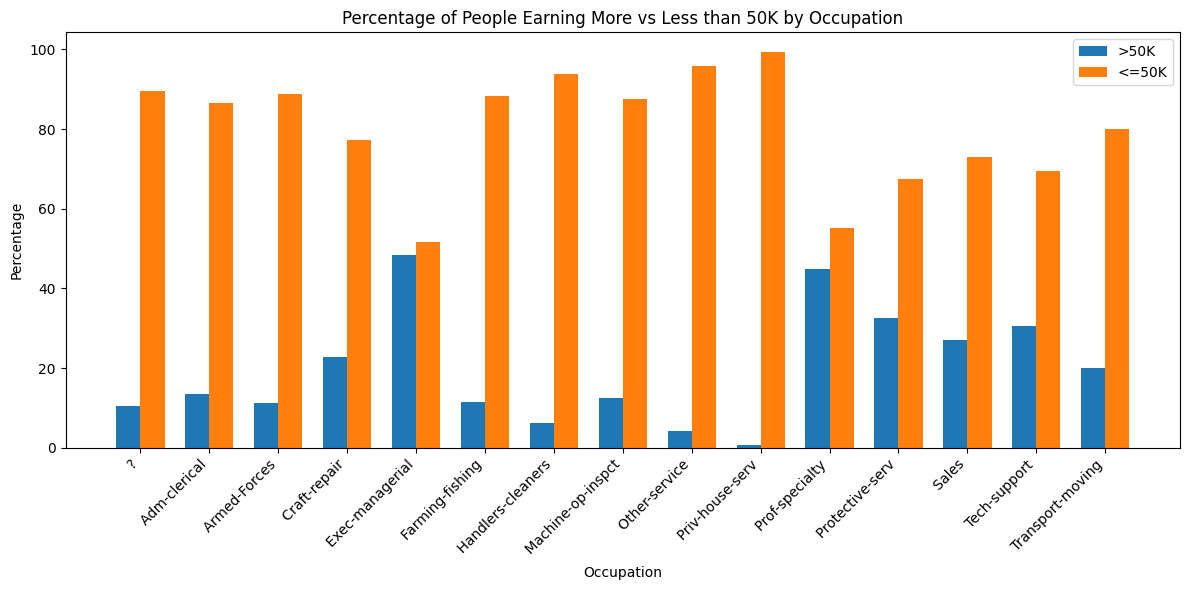

In [21]:
occupation_counts = more_than_50k['occupation'].value_counts()
total_occupation_value = df['occupation'].value_counts()
percent_occupation = (occupation_counts/total_occupation_value)*100
occupation_less_than_50k = (less_than_50k['occupation'].value_counts() / df['occupation'].value_counts()) * 100
occupation_comparison = pd.DataFrame({
    '>50K': percent_occupation,
    '<=50K': occupation_less_than_50k
})
occupation_comparison = occupation_comparison.dropna()
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(occupation_comparison))
bar1 = ax.bar(index, occupation_comparison['>50K'], bar_width, label='>50K')
bar2 = ax.bar(index + bar_width, occupation_comparison['<=50K'], bar_width, label='<=50K')
ax.set_xlabel('Occupation')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of People Earning More vs Less than 50K by Occupation')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(occupation_comparison.index, rotation=45, ha='right')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values


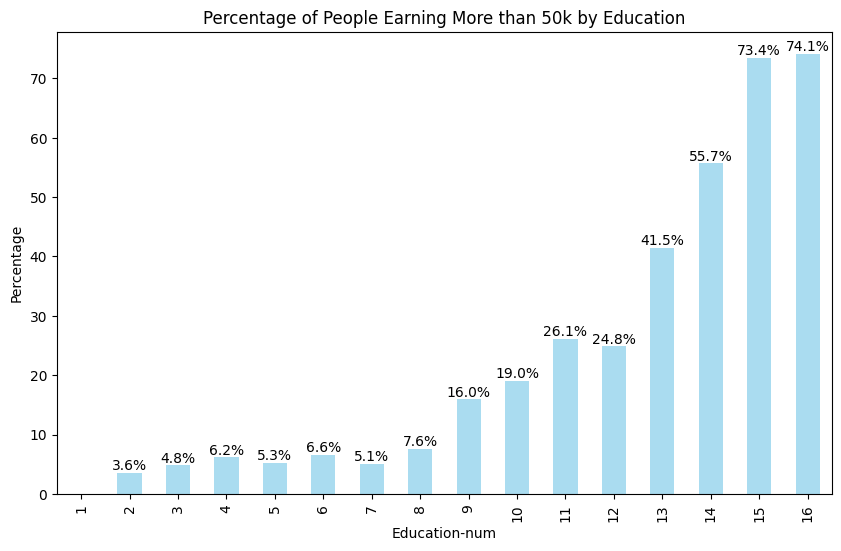

In [22]:
# Calculate percentage and sort by index (education-num) to ensure correct order
percent_of_people = (more_than_50k['education-num'].value_counts() / df['education-num'].value_counts()).sort_index() * 100

# Plotting the data
plt.figure(figsize=(10,6))
ax = percent_of_people.plot(kind='bar', color='skyblue', label='>50K Percentage', alpha=0.7)

# Adding percentage labels athe bars
for i, percent in enumerate(percent_of_people):
    ax.text(i, percent + 0.5, f'{percent:.1f}%', ha='center', fontsize=10, color='black')

# Titles and labels
plt.title('Percentage of People Earning More than 50k by Education')
plt.xlabel('Education-num')
plt.ylabel('Percentage')
plt.show()


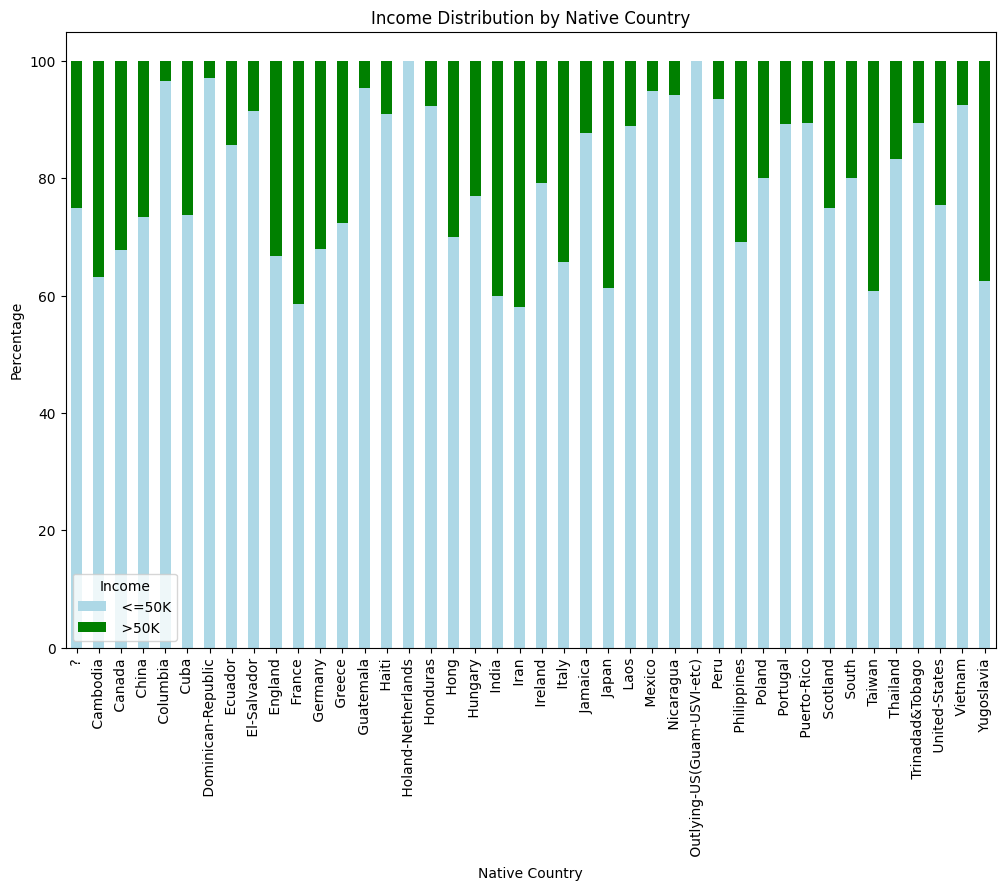

In [23]:
# Group data by native-country and income
country_income = df.groupby(['native-country', 'Target']).size().unstack().fillna(0)

# Normalize the data to show percentages
country_income = country_income.div(country_income.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
country_income.plot(kind='bar', stacked=True, figsize=(12,8), color=['lightblue', 'green'])
plt.title('Income Distribution by Native Country')
plt.xlabel('Native Country')
plt.ylabel('Percentage')
plt.legend(title='Income')
plt.xticks(rotation=90)
plt.show()


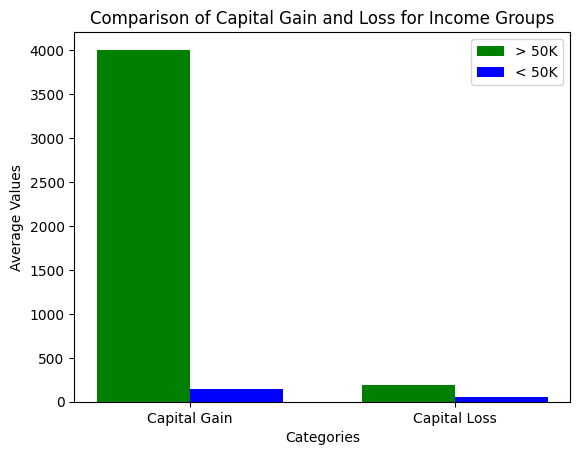

In [24]:

capital_gain_more_than_50K = more_than_50k['capital-gain'].mean()
capital_gain_less_than_50K = less_than_50k['capital-gain'].mean()
capital_loss_more_than_50K = more_than_50k['capital-loss'].mean()
capital_loss_less_than_50K = less_than_50k['capital-loss'].mean()


categories = ['Capital Gain', 'Capital Loss']
more_than_50K = [capital_gain_more_than_50K, capital_loss_more_than_50K]
less_than_50K = [capital_gain_less_than_50K, capital_loss_less_than_50K]

x = np.arange(len(categories))


bar_width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width/2, more_than_50K, bar_width, label='> 50K', color='green')
bar2 = ax.bar(x + bar_width/2, less_than_50K, bar_width, label='< 50K', color='blue')


ax.set_xlabel('Categories')
ax.set_ylabel('Average Values')
ax.set_title('Comparison of Capital Gain and Loss for Income Groups')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()


plt.show()



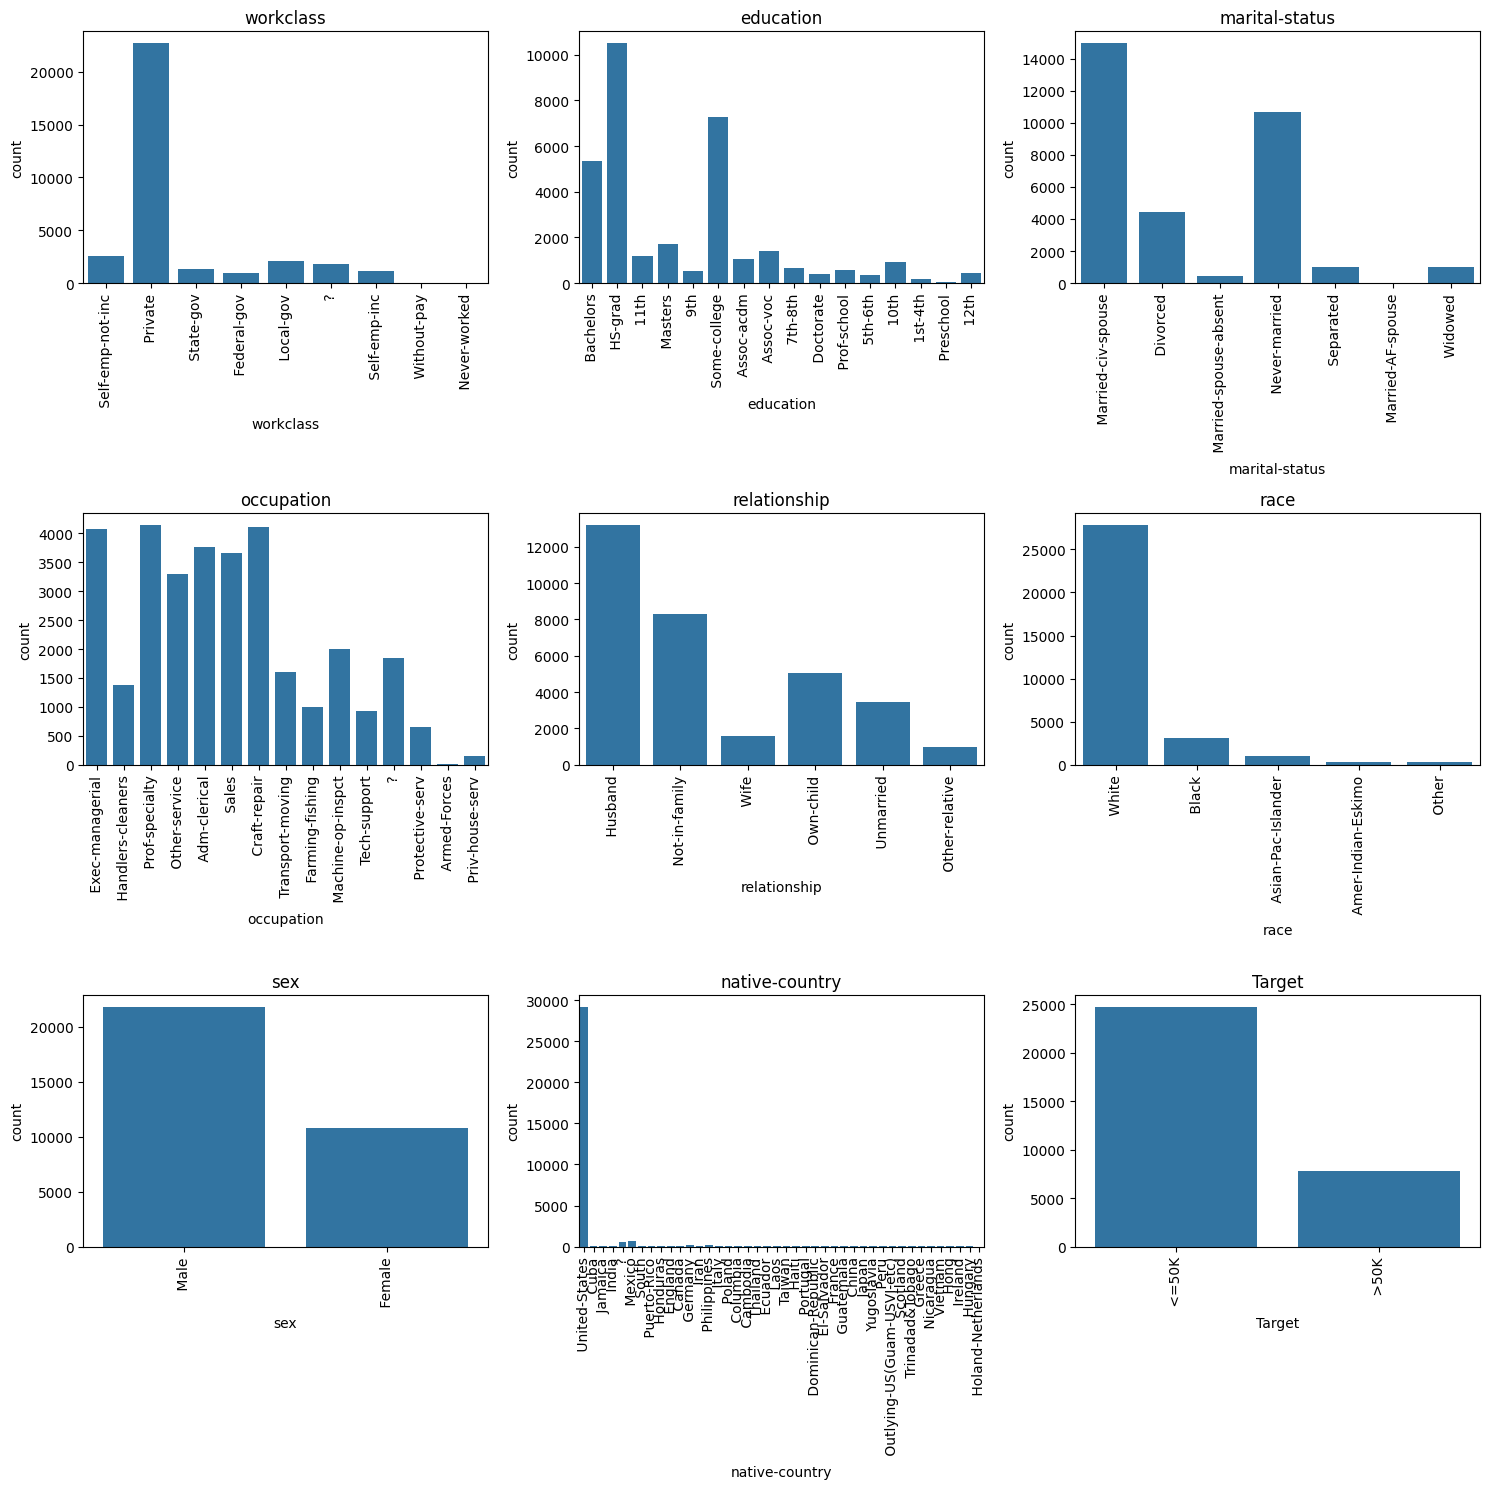

In [25]:
# Get the names of all columns with data type 'object' (categorical columns) excluding 'Country'
cat_vars = df.select_dtypes(include='object').columns.tolist()

# Create a figure with subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Create a countplot for the top 6 values of each categorical variable using Seaborn
for i, var in enumerate(cat_vars):
    top_values = df[var].value_counts().index
    filtered_df = df[df[var].isin(top_values)]
    sns.countplot(x=var, data=filtered_df, ax=axs[i])
    axs[i].set_title(var)
    axs[i].tick_params(axis='x', rotation=90)

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

# Show plot
plt.show()

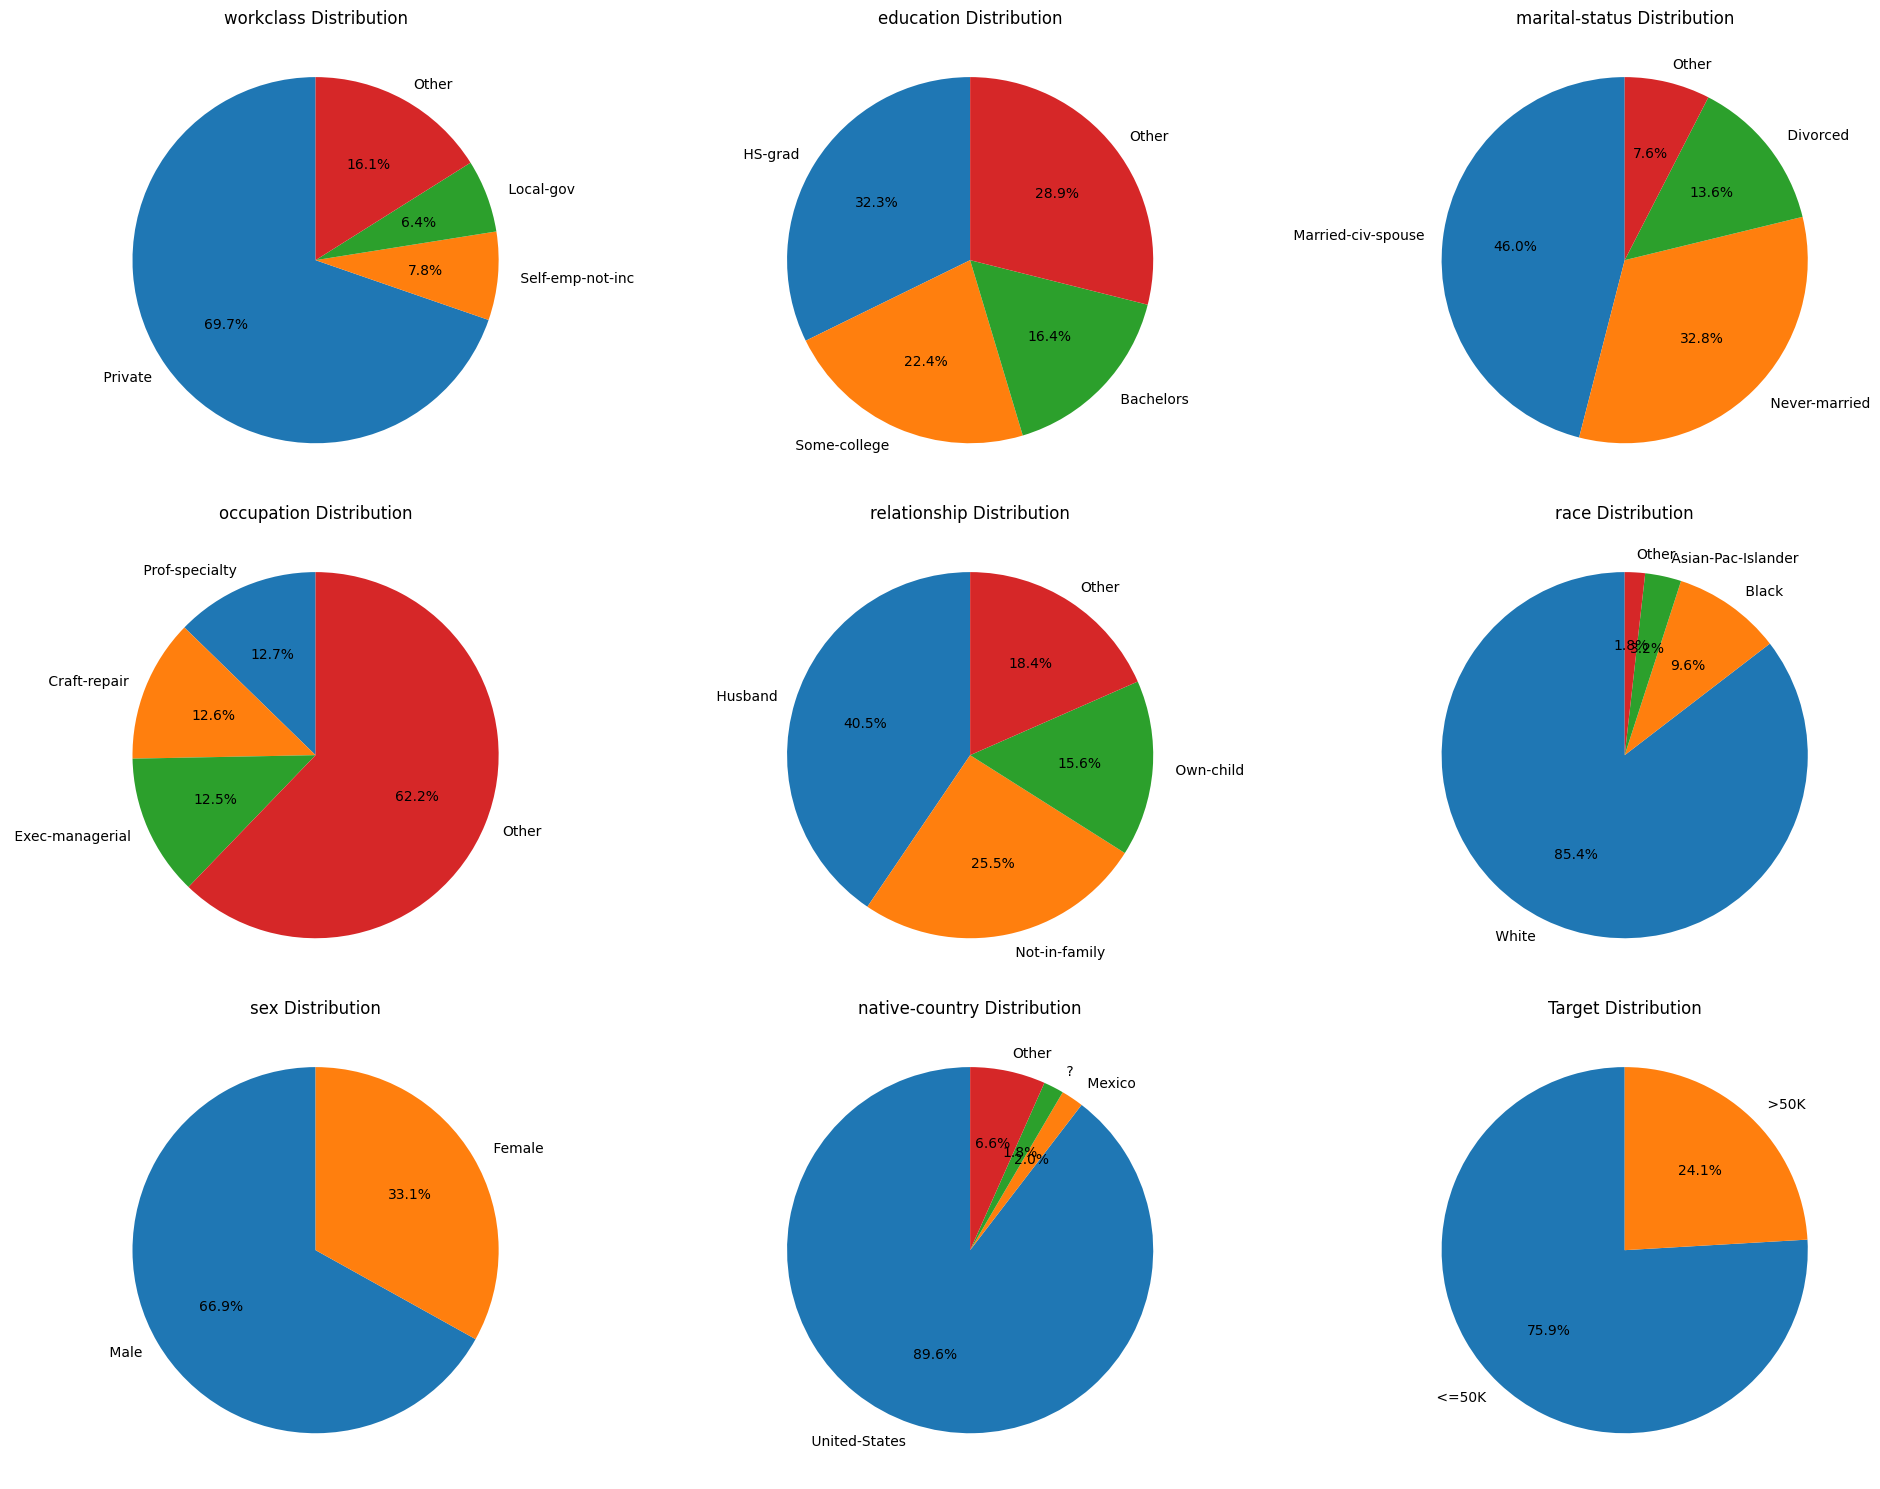

In [26]:

max_categories = 3

# Filter categorical columns with 'object' data type
cat_cols = [col for col in df.columns if col != 'y' and df[col].dtype == 'object']

# Create a figure with subplots
num_cols = len(cat_cols)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5*num_rows))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Create a pie chart for each categorical column
for i, col in enumerate(cat_cols):
    if i < len(axs):  # Ensure we don't exceed the number of subplots
        # Count the number of occurrences for each category
        cat_counts = df[col].value_counts()
        
        # Group categories beyond the top max_categories as 'Other'
        if len(cat_counts) > max_categories:
            cat_counts_top = cat_counts.nlargest(max_categories)
            other_count = cat_counts.sum() - cat_counts_top.sum()
            cat_counts_final = pd.concat([cat_counts_top, pd.Series({'Other': other_count})])
        else:
            cat_counts_final = cat_counts
        
        # Create a pie chart
        axs[i].pie(cat_counts_final.values, labels=cat_counts_final.index, autopct='%1.1f%%', startangle=90)
        axs[i].set_title(f'{col} Distribution')

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
plt.tight_layout()

# Show plot
plt.show()

# Skewness of continuous variable in dataset

In [27]:
continuous_columns = df.select_dtypes(include=['int64','float64']).columns
skewness_values = {}
for col in continuous_columns:
        skew_data = skew(df[col])
        skewness_values[col] = skew_data
        print(f'skewness of {col}: {skew_data}')
        
        

skewness of age: 0.5587118988154982
skewness of fnlwgt: 1.4469055818253151
skewness of education-num: -0.31161553498633193
skewness of capital-gain: 11.953139157554617
skewness of capital-loss: 4.594337190555792
skewness of hours-per-week: 0.2276253044722967


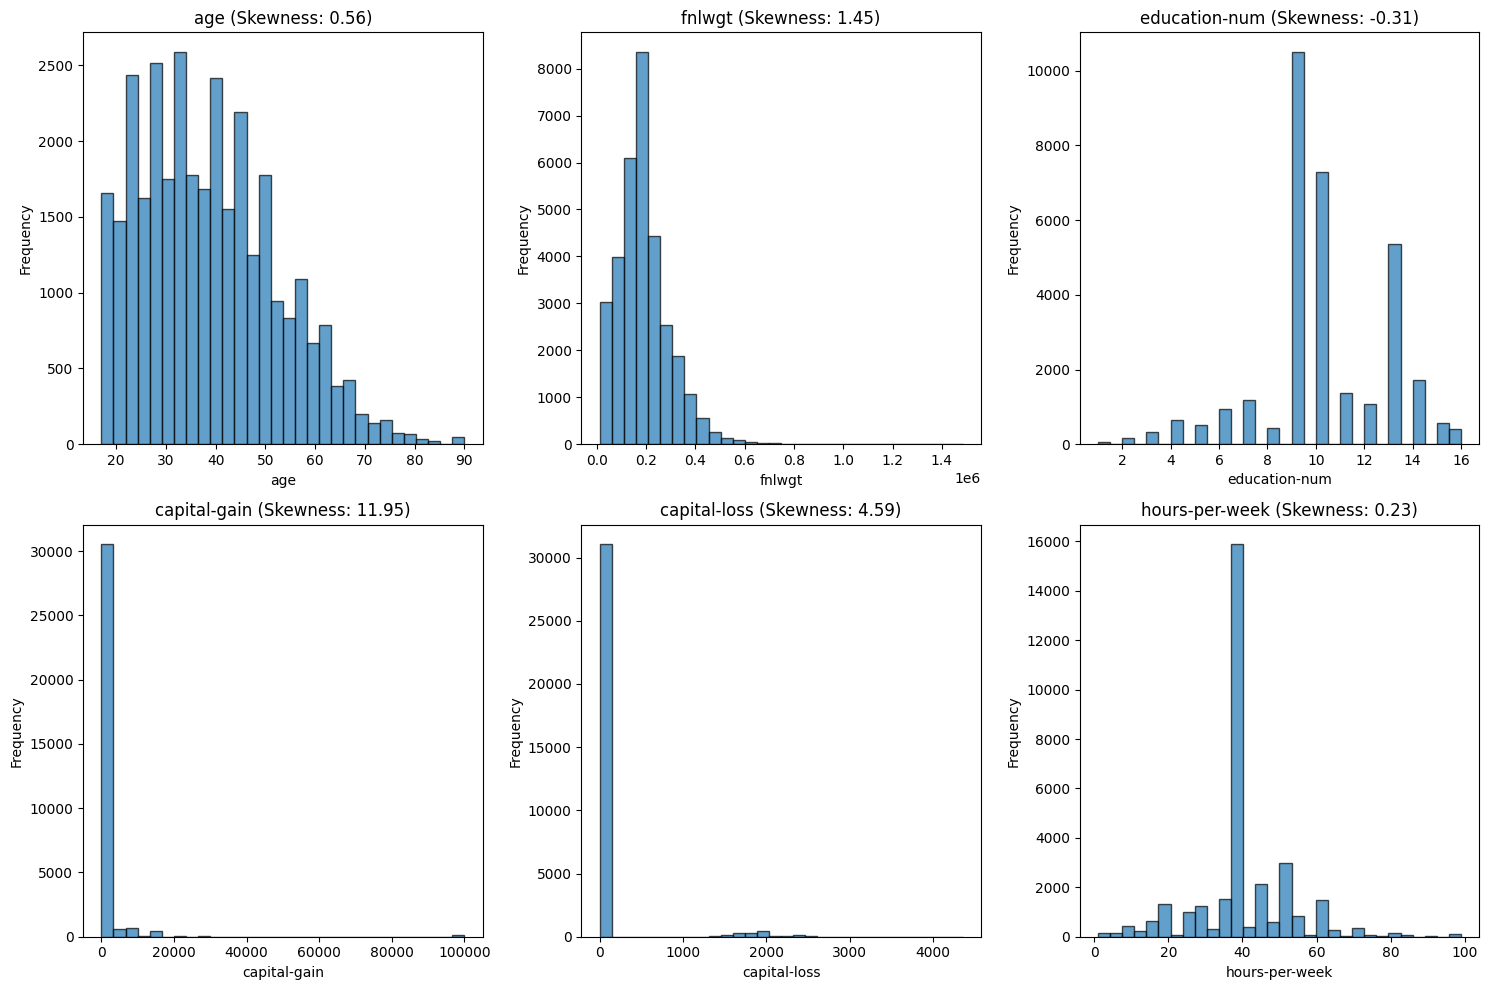

In [28]:

# Number of rows and columns for subplots
n_rows = math.ceil(len(continuous_columns) / 3)  # 3 columns per row
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))  # Correct plt.subplots()

# Flatten axes if necessary
if n_rows == 1 and len(continuous_columns) <= 3:
    axes = axes.flatten()  # If only 1 row, treat it as a 1D array
elif n_rows > 1:
    axes = axes.flatten()  # For multiple rows, always flatten

# Plot histograms with skewness
for i, col in enumerate(continuous_columns):
    ax = axes[i]
    ax.hist(df[col].dropna(), bins=30, edgecolor='k', alpha=0.7)
    ax.set_title(f'{col} (Skewness: {skewness_values[col]:.2f})')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')


#for j in range(i + 1, len(axes)):
 #   fig.delaxes(axes[j])

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


# Skewness transformation strategies

In [29]:
df['capital_gain_flag'] = np.where(df['capital-gain']> 0, 1, 0)
df['capital_gain_log'] = np.where(df['capital-gain'] > 0, np.log(df['capital-gain']+1), 0)

df['capital_loss_flag'] = np.where(df['capital-loss'] > 0, 1, 0)
df['capital_loss_log']  = np.where(df['capital-loss'] > 0, np.log(df['capital-loss']+1),0)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target,capital_gain_flag,capital_gain_log,capital_loss_flag,capital_loss_log
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,0.0,0,0.0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0,0.0,0,0.0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0,0.0,0,0.0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0,0.0,0,0.0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,0,0.0,0,0.0


In [30]:
df = df.drop(columns=['capital-gain','capital-loss'], axis = 1)

In [31]:
from sklearn import preprocessing
for col in df.select_dtypes(include='object').columns:
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df[col].unique())
    df[col] = label_encoder.transform(df[col])
    print(f'{col} {df[col].unique()}')

workclass [6 4 7 1 2 0 5 8 3]
education [ 9 11  1 12  6 15  7  8  5 10 14  4  0  3 13  2]
marital-status [2 0 3 4 5 1 6]
occupation [ 4  6 10  8  1 12  3 14  5  7 13  0 11  2  9]
relationship [0 1 5 3 4 2]
race [4 2 1 0 3]
sex [1 0]
native-country [39  5 23 19  0 26 35 33 16  9  2 11 20 30 22 31  4  1 37  7 25 36 14 32
  6  8 10 13  3 24 41 29 28 34 38 12 27 40 17 21 18 15]
Target [0 1]


<Axes: >

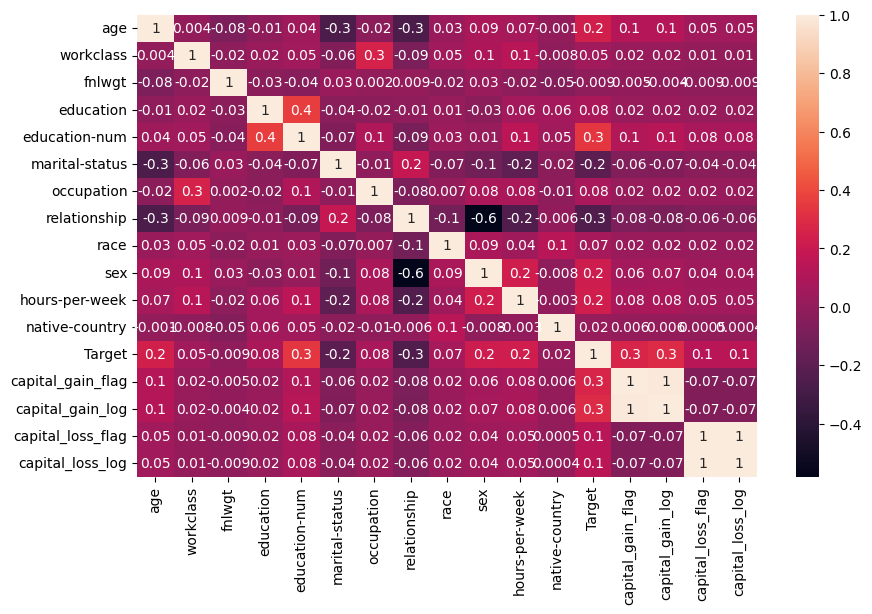

In [32]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),fmt='.1g',annot=True)

# Standardization of dataset 

In [33]:
continuous_feature = df.select_dtypes(include=['int64','float64']).columns
continuous_df = df.loc[:,continuous_feature]
categorical_feature = df.select_dtypes(include=['int32','object']).columns
categorical_df = df.loc[:,categorical_feature]

from sklearn.preprocessing import StandardScaler
sacaler = StandardScaler()
scaled_data = sacaler.fit_transform(continuous_df)
scaled_df = pd.DataFrame(scaled_data, columns=continuous_df.columns)
Standard_df = pd.concat([scaled_df, categorical_df.reset_index(drop=True)], axis=1)
Standard_df.head()

,age,fnlwgt,education-num,hours-per-week,capital_gain_log,capital_loss_log,workclass,education,marital-status,occupation,relationship,race,sex,native-country,Target,capital_gain_flag,capital_loss_flag
0,0.837097,-1.008742,1.134779,-2.22212,-0.299216,-0.221078,6,9,2,4,0,4,1,39,0,0,0
1,-0.042640,0.245046,-0.420027,-0.03543,-0.299216,-0.221078,4,11,0,6,1,4,1,39,0,0,0
2,1.057031,0.425770,-1.197429,-0.03543,-0.299216,-0.221078,4,1,2,6,0,2,1,39,0,0,0
3,-0.775755,1.408146,1.134779,-0.03543,-0.299216,-0.221078,4,9,2,10,5,2,0,5,0,0,0
4,-0.115952,0.898170,1.523480,-0.03543,-0.299216,-0.221078,4,12,2,4,5,4,0,39,0,0,0


# Training the model and splitting the data

In [34]:
X = Standard_df.drop('Target', axis=1)
y = Standard_df['Target']

In [35]:
X_train_, X_test, y_train_, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [36]:
unique_categories, counts = np.unique(y_train_, return_counts=True)
print("\nCounts of each category:")
print(counts)


Counts of each category:
[19762  6286]


# Smote technique for handling imbalanced class dataset

In [37]:
smot = SMOTE(random_state=42)
X_train , y_train = smot.fit_resample(X_train_, y_train_)

In [38]:
unique_categories, counts = np.unique(y_train, return_counts=True)
print("\nCounts of each category:")
print(counts)


Counts of each category:
[19762 19762]


In [39]:
log_reg = LogisticRegression()

In [40]:
log_reg.fit(X_train,y_train)

C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Accuracy of model with all features 

In [41]:
y_pred = log_reg.predict(X_test)

In [42]:
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy :{accuracy*100:.2f}%')

accuracy :77.60%


# Feature engineering with coffiecient magnitude analysis

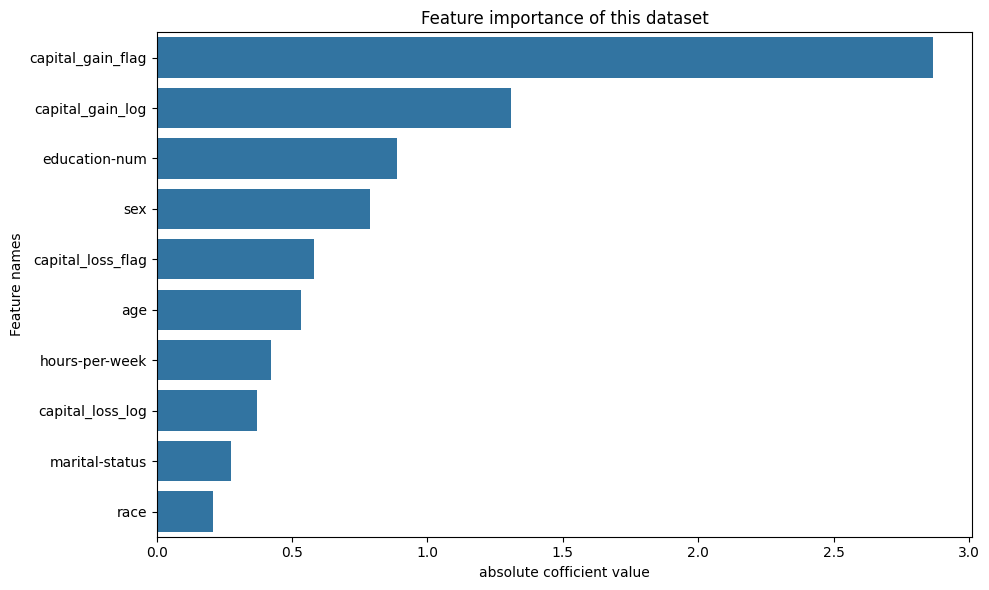

In [43]:
importances = np.abs(log_reg.coef_[0])
imp_df = pd.DataFrame({"feature_name" : X_train.columns,
          "importance":importances})
fi = imp_df.sort_values(by="importance", ascending=False)

top_features = fi.head(10)
plt.figure(figsize=(10,6))
sns.barplot(data = top_features, x='importance', y='feature_name')
plt.title('Feature importance of this dataset')
plt.xlabel('absolute cofficient value')
plt.ylabel('Feature names')
plt.tight_layout()
plt.show()




In [44]:
top_feature_names = top_features['feature_name'].tolist()
X_train_reduced = X_train[top_feature_names]
X_test_reduced = X_test[top_feature_names] 

In [45]:
log_reg_1 = LogisticRegression()

In [46]:
log_reg_1.fit(X_train_reduced, y_train)

LogisticRegression()

In [47]:
y_pred_1 = log_reg_1.predict(X_test_reduced)

# Accuracy after feature engineering 

In [48]:
accuracy_1 = accuracy_score(y_test, y_pred_1)
print(f'accuracy:{accuracy_1*100:.2f}')


accuracy:77.81


Accuracy is same before and after the feature engineering it means our feature engineering works

# Hyper parameter tuning for logistic regression

In [49]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  # 'liblinear' supports only 'l1' and 'l2' penalties
    'solver': ['liblinear'],  # limit to 'liblinear' for 'l1' and 'l2' penalties
    'max_iter': [100, 200, 300]
}

# Add a second grid for saga solver with elasticnet and no regularization support
param_grid_saga = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Use 'none' as a string for no regularization
    'solver': ['saga'],  # 'saga' supports 'l1', 'l2', 'elasticnet', and 'none'
    'max_iter': [100, 200, 300],
    'l1_ratio': [0.5]  # required for 'elasticnet' penalty
}

# Use both parameter grids in a list
grid_search = GridSearchCV(
    LogisticRegression(),
    [param_grid, param_grid_saga],
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    error_score='raise'  # will raise errors if there are invalid parameter combinations
)

# Fit the model
grid_search.fit(X_train_reduced, y_train)

# Output the best parameters
print(f'Best parameter: {grid_search.best_params_}')


Best parameter: {'C': 1, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}


In [50]:
best_log_reg = LogisticRegression(
    C = 100, max_iter=200, penalty= 'l1', solver= 'liblinear' 
)
best_log_reg.fit(X_train_reduced,y_train)

C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=100, max_iter=200, penalty='l1', solver='liblinear')

In [51]:
y_pred_best = best_log_reg.predict(X_test_reduced)
print(f'Accuracy : {accuracy_score(y_pred_best, y_test)*100:.2f}')

Accuracy : 78.15


In [52]:
print(f'Precision of the Model : {precision_score(y_test, y_pred_best):.2f}')

Precision of the Model : 0.53


# Ensemble technique for improving model accuracy 

In [70]:
scale_weight_pos = sum(y_train == 0)/sum(y_train == 1)

In [71]:
xgb_clf = XGBClassifier(
    objective = 'binary:logistic',
    scale_pos_weight = scale_weight_pos,
    learning_rate = 0.1,
    max_depth = 6,
    n_estimators = 100,
    use_label_encoder = False,
    eval_metric = 'logloss'
)


In [72]:
xgb_clf.fit(X_train_reduced,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [73]:
xgb_pred = xgb_clf.predict(X_test_reduced)

In [78]:
print("Classification Report:\n", classification_report(y_test, xgb_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      4957
           1       0.63      0.82      0.71      1555

    accuracy                           0.84      6512
   macro avg       0.78      0.83      0.80      6512
weighted avg       0.86      0.84      0.85      6512



# Hyperparameter Tuning for optimal parameter of XGboost algorithm

In [79]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 1, 5]
}

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='f1', cv=5, n_jobs=-1, verbose=2)

In [80]:
grid_search.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1]},
             scoring='f1', verbose=2)

In [84]:
best_params = grid_search.best_params_
xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train_reduced, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [85]:
xgb_pred = xgb_best.predict(X_test_reduced)

In [86]:
print("Classification Report:\n", classification_report(y_test, xgb_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      4957
           1       0.67      0.73      0.70      1555

    accuracy                           0.85      6512
   macro avg       0.79      0.81      0.80      6512
weighted avg       0.85      0.85      0.85      6512



In [108]:
result_df = pd.DataFrame(
{'Actual': y_test,
'Predicted' : xgb_pred})


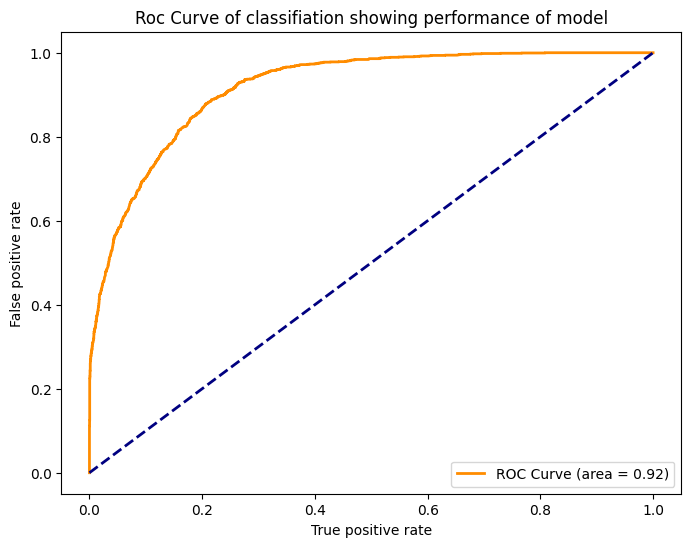

In [118]:
y_pred_prob = xgb_best.predict_proba(X_test_reduced)[:,1]
fpr, tpr , thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1] , color = 'navy', lw =2, linestyle = '--')
plt.title('Roc Curve of classifiation showing performance of model')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.legend(loc='lower right')
plt.show()


## Below is the detailed report of Data  Science Project key insights and model Training Results

# Data Science Project Report

## 1. Introduction
The goal of this analysis is to determine the factors influencing whether an individual earns more or less than $50K. Using various machine learning techniques, including feature engineering, logistic regression, and ensemble methods like XGBoost, we evaluate performance through classification metrics like accuracy, AUC, and more.

## 2 Exploratory Data Analysis (EDA)

### 2.1 Capital Gain and Loss: Risk Appetite of High Earners
Individuals who earn more than $50K show higher levels of capital gains and losses, suggesting a higher tolerance for financial risk. Here are the mean values observed:
- **Capital Gain (>50K)**: 4006.14
- **Capital Gain (<50K)**: 148.67
- **Capital Loss (>50K)**: 195.00
- **Capital Loss (<50K)**: 53.15


![Capital gain vs Capital loss](Capitalgainvscapitalloss.png "Capital vs Capital loss for people earning more than and less than 50k" )

### 2.2 Age Distribution and Earnings
There is a positive correlation between age and earning potential. Younger individuals (below 30) tend to earn less than $50K, while older individuals (around 50 or higher) are more likely to earn more.


![Age Distribution](Age%20Distribution.png "Age vs Earning Distribution")

### 2.3 Correlation Between Education and Earnings
Higher education levels correspond to higher earnings. As the education level increases, the likelihood of earning more than $50K also increases.


![Earning and Education](Earningandeduction.png "Earning vs Education Level")

### 2.4 Country-Specific Insights
Certain countries have a higher proportion of individuals earning more than $50K. Leading countries include Iran, France, and India.

![Income by Native Country](incomebynativecountry.png "Country-Specific Insights")

## 3. Data Preprocessing and Feature Engineering
Data preprocessing steps included:
- **Standardization**: Ensuring that all numerical features have the same scale.
- **Label Encoding**: For categorical variables.
- **Minimizing Skewness**: Handling outliers and transforming skewed features to approximate normal distributions.
### Feature Engineering
Feature engineering was applied to derive meaningful features from the raw dataset, improving model performance.

![Feature Engineering](Feature%20Engineering.png "Feature Engineering Techniques")

## 4. Model Training and Evaluation

### 4.1 Logistic Regression
We used Logistic Regression as the baseline model for classification. The logistic regression model was trained using:
- **Hyperparameter tuning**: Conducted using GridSearchCV to optimize parameters such as regularization strength and solver.
- **SMOTE**: Applied to handle class imbalance in the dataset.

### 4.2 Ensemble Technique: XGBoost Classifier
XGBoost was employed to further boost classification performance. This method is highly efficient and handles imbalanced classes well.

### 4.3 Hyperparameter Tuning
GridSearchCV was utilized to find the optimal hyperparameters for the logistic regression and XGBoost classifiers.

### 4.4 Evaluation Metrics
The performance of the models was evaluated based on several metrics:
- **Accuracy**: 0.85
- **Precision**: 
  - Class 0 (less than $50K): 0.91
  - Class 1 (more than $50K): 0.67
- **Recall**:
  - Class 0: 0.89
  - Class 1: 0.73
- **F1-Score**: 
  - Class 0: 0.90
  - Class 1: 0.70
- **AUC Score**: 0.92

### 4.5 ROC Curve for XGBoost
The ROC curve for the XGBoost classifier illustrates the trade-off between the true positive rate and the false positive rate.

![ROC Curve](Roc_curve.png "ROC Curve for XGBoost")
```markdown

